In [28]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from itertools import combinations

import matplotlib.pyplot as plt

In [29]:
gb = pd.read_csv("Data/csv/GB_10yr_2000.csv")
jpy = pd.read_csv("Data/csv/JPY_10yr_2000.csv")
ger = pd.read_csv("Data/csv/GER_10yr_2000.csv")
usd = pd.read_csv("Data/csv/US10_yr_2000.csv")

gb_series = gb['PX_LAST']
jpy_series = jpy['PX_LAST']
ger_series = ger['PX_LAST']
usd_series = usd['PX_LAST']

gb_series.name = 'GB 10yr'
jpy_series.name = 'JPY 10yr'
ger_series.name = 'GER 10yr'
usd_series.name = 'US 10yr'

coint_pairs = []
coint_pairs.append((gb_series[:5911], jpy_series[:5911]))
coint_pairs.append((ger_series[:5911], gb_series[:5911]))
coint_pairs.append((usd_series[:5911], ger_series[:5911]))

In [30]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    # adfuller (augmented dicky fuller test) is a statistically significant test for stationary dataset
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

p-value = 0.038021369895216116 The series GB 10yr - 3.153806293353844 * JPY 10yr is likely stationary.
p-value = 0.5445426807800632 The series GER 10yr - 0.8126886719496381 * GB 10yr is likely non-stationary.
p-value = 0.6594750597808761 The series US 10yr - 1.1007319584030395 * GER 10yr is likely non-stationary.


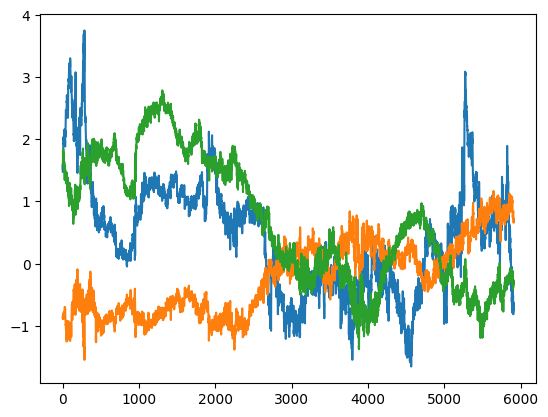

In [48]:
for pair in coint_pairs:
    model = sm.OLS(pair[0], pair[1]).fit()
    model.summary()
    beta = model.params.iloc[0]
    series = pair[0] - beta * pair[1]
    series.name = f"{pair[0].name} - {beta} * {pair[1].name}"
    stationary = check_for_stationarity(series, 0.05)
    plt.plot(pair[0].index, pair[0] - beta * pair[1])


# Index Coint Pairs

In [40]:
Asia_Pac_index = pd.read_csv("Data/csv/AsiaPacAggIdx_2000.csv")
EM_index = pd.read_csv("Data/csv/EMAggIdx_2000.csv")
Global_Agg_index = pd.read_csv("Data/csv/GlobalAggIdx_2000.csv")
PanEuro_Index = pd.read_csv("Data/csv/PanEuroAggIdx_2000.csv")
US_index = pd.read_csv("Data/csv/USAggIdx_2000.csv")

In [58]:
series_list = []
Asia_Pac_series = Asia_Pac_index['PX_LAST']
Asia_Pac_series.name = 'Asia_Pac'
Asia_Pac_series.index = Asia_Pac_index['Date']
EM_series = EM_index['PX_LAST']
EM_series.name = 'EM'
EM_series.index = EM_index['Date']
Global_Agg_series = Global_Agg_index['PX_LAST']
Global_Agg_series.name = 'Global_Agg'
Global_Agg_series.index = Global_Agg_index['Date']
PanEuro_series = PanEuro_Index['PX_LAST']
PanEuro_series.name = 'PanEuro'
PanEuro_series.index = PanEuro_Index['Date']
US_series = US_index['PX_LAST']
US_series.name = 'US'
US_series.index = US_index['Date']

series_list.append(Asia_Pac_series)
series_list.append(EM_series)
series_list.append(Global_Agg_series)
series_list.append(PanEuro_series)
series_list.append(US_series)


# normalize series length to 5756
coint_series = []
for series in series_list:
    coint_series.append(series[:5756])


In [61]:
# check for cointegration
# 5 choose 2 -> 10 pairs

pairs = list(combinations(coint_series, 2))
for pair in pairs:
    coint_t, p_val, _ = coint(pair[0], pair[1])
    # align dates
    df1 = pair[0].to_frame('series1')
    df2 = pair[1].to_frame('series2')
    aligned_df = df1.merge(df2, left_index=True, right_index=True, how='inner')
    new_series1 = aligned_df['series1']
    new_series2 = aligned_df['series2']

    print(new_series1)
    print(new_series2)
    if p_val < .05:
        print(f"Potentially Cointegrated: {p_val}: {pair[0].name}, {pair[1].name}")
        model = sm.OLS(new_series1, new_series2).fit()
        model.summary()
        beta = model.params.iloc[0]
        series = pair[0] - beta * pair[1]
        """
        series.name = f"{pair[0].name} - {beta} * {pair[1].name}"
        stationary = check_for_stationarity(series, 0.05)
        if (stationary):
        """
        stationary = check_for_stationarity(series, 0.05)
        print()
        plt.plot(new_series1.index, series)
        
    else:
        print(f"Not Cointegrated: {p_val}: {pair[0].name}, {pair[1].name}\n")

Date
11/2/2023     173.8605
11/1/2023     173.4825
10/31/2023    173.8414
10/30/2023    172.6046
10/27/2023    172.9983
                ...   
3/12/2001     104.6439
3/9/2001      104.4607
3/8/2001      104.6271
3/7/2001      104.7753
3/6/2001      104.6204
Name: series1, Length: 5552, dtype: float64
Date
11/2/2023     1082.1510
11/1/2023     1072.1280
10/31/2023    1067.2630
10/30/2023    1066.9990
10/27/2023    1066.9950
                ...    
3/12/2001      277.3243
3/9/2001       278.5853
3/8/2001       278.2534
3/7/2001       278.8092
3/6/2001       277.8706
Name: series2, Length: 5552, dtype: float64
Potentially Cointegrated: 0.017175020042994243: Asia_Pac, EM


MissingDataError: exog contains inf or nans